In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import math

# read 3D SPECT raw data
imgData = np.fromfile('whole_bone.raw', dtype="float32")
# According to Document, the data was captured in 60 frames,
# projection of a single frame is 128*128 matrix.
proj = imgData.reshape(60,128,128)
#for convenience
square = 128*128

# theta is rotation angle from the starting -x, around z axis
def get_spect_tran_m(theta):
    bias = 1e-6
    # {cij} system matrix 
    c = np.zeros((square,128),dtype="float32")
    # np.linspace is a method for arithmetic progression
    # i is the coordinate at r axis on detector
    for i in np.linspace(-63.5,63.5,128):
        # ang is rotation angle from +x, couter-clockwise
        ang = math.pi-theta/180*math.pi
        # vertical distance line from FOV center to detector
        slope = math.tan(ang)
        # intercept on y axis
        intercept = i/math.cos(ang+bias)
        # delta model of {cij}
        # ray driven ergodic, No. c_j detector cell
        c_j = int(i+63.5)
        if slope<=0:  
            for x in range(-63,65):
                for y in range(-63,65):
                    x2 = x-1
                    y2 = y-1
                    if (slope*x+intercept-y)*(slope*x2+intercept-y2) <=0:
                        c_i = (x+63)*128+y+63
                        c[c_i,c_j] = 1
        else:
            for x in range(-63,65):
                for y in range(-63,65):
                    x1 = x-1
                    y1 = y
                    x2 = x
                    y2 = y-2
                    if (slope*x1+intercept-y1)*(slope*x2+intercept-y2) <=0:
                        c_i = (x+63)*128+y+63
                        c[c_i,c_j] = 1
    return c

# actual rotation angle, 6 degree a frame
theta_sample = np.arange(0,60,dtype="float32")*6
bias = 1e-6
# when theta = n*90 deg
theta_sample[np.linspace(0,45,4,dtype = "int")] = theta_sample[np.linspace(0,45,4,dtype="int")] + bias
# system matrix for 60 frames, same for every layer along z axis
frame_c = {}
i = 0

# tqdm to create a progress bar 0-60, based on loop
for n in tqdm(range(0,60)):
    num = str(i)
    frame_c[num] = get_spect_tran_m(theta_sample[i])
    i = i + 1

# to pile the 60 frames of system matrix in one matrix
total_c = np.zeros((square,128*60),dtype="float32")
for i in range(0,59):
    range1 = 128*i
    range2 = 128*(i+1) 
    # store system matrix of 60 frames
    total_c[:,range1:range2] = frame_c[str(i)]

# reconstrunction image
osem_spect = np.zeros((128,128,128),dtype="float32")

# iter means iteration times
# divide the dataset to sub subsets
# sub should be the factor of 60
def OSEM_SPECT(i,sub,iter):
    a=np.linspace(0,128*60,sub+1,dtype="int")
    # No. i slice on z axis
    proj_slice = proj[:,i,:]
    total_p = proj_slice.reshape(1,128*60).squeeze(0)
    f_old = np.ones((1,square),dtype="float32").squeeze(0)
    f_new = np.ones((1,square),dtype="float32").squeeze(0)
    for index in range(0,iter):
        for j in range(1,sub):
            f_new = (f_old/np.sum(total_c[:,a[j]:a[j+1]]+bias,axis=1))*total_c[:,a[j]:a[j+1]].dot(total_p[a[j]:a[j+1]]/(f_old.dot(total_c[:,a[j]:a[j+1]]+bias)))
            f_old = f_new
    return f_old.reshape(128,128)

100%|██████████| 60/60 [02:35<00:00,  2.58s/it]


In [2]:
# i in progress bar represents the i th layer on z axis
for i in tqdm(range(0,128)):
    osem_spect[i] = OSEM_SPECT(i,4,4)

100%|██████████| 128/128 [05:18<00:00,  2.48s/it]


In [8]:
# to view in Amide or Matlab
osem_spect.tofile("osem_test.raw")

# According to ICRP Publication 210, representative profiles should be:
# transversal no. 147, 158, 168, 207
# coronal no. 87
# sagittal no. 109

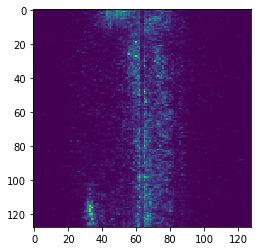

In [7]:
# to view a transversal profile
plt.imshow(osem_spect[64,:,:])
plt.savefig('44-1.png')
plt.imshow(osem_spect[:,64,:])
plt.savefig('44-2.png')
plt.imshow(osem_spect[:,:,64])
plt.savefig('44-3.png')

10:32,  6.45s/it]

 24%|██▍       | 31/128 [03:16<10:26,  6.46s/it]

 25%|██▌       | 32/128 [03:23<10:19,  6.45s/it]

 26%|██▌       | 33/128 [03:29<10:16,  6.48s/it]

 27%|██▋       | 34/128 [03:36<10:06,  6.46s/it]

 27%|██▋       | 35/128 [03:42<10:00,  6.46s/it]

 28%|██▊       | 36/128 [03:49<09:56,  6.48s/it]

 29%|██▉       | 37/128 [03:55<09:51,  6.50s/it]

 30%|██▉       | 38/128 [04:02<09:41,  6.46s/it]

 30%|███       | 39/128 [04:08<09:30,  6.41s/it]

 31%|███▏      | 40/128 [04:14<09:22,  6.39s/it]

 32%|███▏      | 41/128 [04:21<09:14,  6.37s/it]

 33%|███▎      | 42/128 [04:27<09:07,  6.37s/it]

 34%|███▎      | 43/128 [04:33<09:00,  6.36s/it]

 34%|███▍      | 44/128 [04:40<08:57,  6.40s/it]

 35%|███▌      | 45/128 [04:46<08:50,  6.39s/it]

 36%|███▌      | 46/128 [04:53<08:45,  6.41s/it]

 37%|███▋      | 47/128 [04:59<08:39,  6.41s/it]

 38%|███▊      | 48/128 [05:06<08:33,  6.42s/it]

 38%|███▊      | 49/128 [05:12<08:25,  6.40s/it]

 39%|███▉      | 50/128 [05:18<

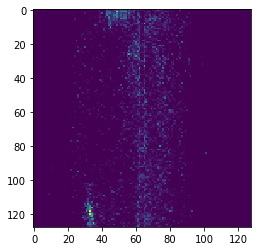

In [10]:
a=[4,4,4,12,12]
b=[4,1,10,1,4]
for j in range(0,5):
    for i in tqdm(range(0,128)):
        osem_spect[i] = OSEM_SPECT(i,a[j],b[j])
    plt.imshow(osem_spect[64,:,:])
    plt.savefig(f'{a[j]}{b[j]}-transverse.png')
    plt.imshow(osem_spect[:,64,:])
    plt.savefig(f'{a[j]}{b[j]}-coronal.png')
    plt.imshow(osem_spect[:,:,64])
    plt.savefig(f'{a[j]}{b[j]}-sagittal.png')
    osem_spect.tofile(f"OSEM_{a[j]}{b[j]}.raw")

In [2]:
# pip install SSIM-PIL
# Comparison of two images using the structural similarity algorithm (SSIM). It's compatible with the PIL. Supports GPU acceleration via pyopencl.

from SSIM_PIL import compare_ssim
from PIL import Image

image1 = Image.open('41-coronal.png')
image2 = Image.open('44-coronal.png')
value = compare_ssim(image1, image2)
print(value)


0.8983199323137989
